# Initialize system

In [1]:
### Setup the library ###
import pyrogue as pr
import os, sys
import matplotlib.pyplot as plt
import time
import datetime
import numpy as np
import math
import pprint
import inspect 
top_level=f'{os.getcwd()}/../'
rootTopLevel = top_level+'script/'
pr.addLibraryPath( rootTopLevel )

import setupLibPaths

import ePix320kM as devBoard

args = None

In [2]:
# ONLY RUN ONCE!
# Defining root
# If crashes, make sure the deve is correct.
root =  devBoard.Root(   
        top_level  = top_level,
        dev        = '/dev/datadev_1',
        pollEn     = False,
        initRead   = True,
        pciePgpEn  = False,
        justCtrl   = False,
        DDebugSize = 4000)
root.start()

# example showing a read
AxiVersion = root.Core.AxiVersion
print ( '###################################################')
print ( '#             Firmware Version                    #')
print ( '###################################################')
AxiVersion.printStatus()
print ( '###################################################')

Root.Core.Si5345Pll.Page0.DataBlock.setPollInterval(1)
Start: Started zmqServer on ports 9099-9101
    To start a gui: python -m pyrogue gui --server='localhost:9099'
    To use a virtual client: client = pyrogue.interfaces.VirtualClient(addr='localhost', port=9099)
Root.Core.AxiVersion count reset called
###################################################
#             Firmware Version                    #
###################################################
Path         = Root.Core.AxiVersion
FwVersion    = 0x1000300
UpTime       = 13 days, 9:03:17
GitHash      = 0x9550c2a95f7e334393e52bfde914e26fb20f11b8
XilinxDnaId  = 0x400200000139d7204c81a145
FwTarget     = ePixHRM320k
BuildEnv     = Vivado v2023.1
BuildServer  = rdsrv314 (Ubuntu 20.04.6 LTS)
BuildDate    = Wed 17 Jan 2024 11:42:17 PM PST
Builder      = dnajjar
###################################################


In [3]:
# Useful short names
APP  = root.App
AXIV = root.Core.AxiVersion
ASICTOP = APP.AsicTop
TRIG = ASICTOP.TriggerRegisters
ASIC0 = APP.Mv2Asic[0]
ASIC1 = APP.Mv2Asic[1]
ASIC2 = APP.Mv2Asic[2]
ASIC3 = APP.Mv2Asic[3]
HSDAC = APP.Dac.FastDac 
PKREG0 = ASICTOP.DigAsicStrmRegisters0
PKREG1 = ASICTOP.DigAsicStrmRegisters1
PKREG2 = ASICTOP.DigAsicStrmRegisters2
PKREG3 = ASICTOP.DigAsicStrmRegisters3
BATCHER0 = ASICTOP.BatcherEventBuilder0
BATCHER1 = ASICTOP.BatcherEventBuilder1
BATCHER2 = ASICTOP.BatcherEventBuilder2
BATCHER3 = ASICTOP.BatcherEventBuilder3
DEBUG0 = root._dbg[0]
DEBUG1 = root._dbg[1]
DEBUG2 = root._dbg[2]
DEBUG3 = root._dbg[3]
DATARCV0 = root.DataReceiver0
DATARCV1 = root.DataReceiver1
DATARCV2 = root.DataReceiver2
DATARCV3 = root.DataReceiver3
FULLRATERCV0 = root.fullRateDataReceiver[0]
FULLRATERCV1 = root.fullRateDataReceiver[1]
FULLRATERCV2 = root.fullRateDataReceiver[2]
FULLRATERCV3 = root.fullRateDataReceiver[3]
DAC = APP.Dac
REGCTRL = ASICTOP.RegisterControlDualClock

In [4]:
# Configure clock to 168 MHz and configures all ASICS
root.InitASIC([4,1,1,1,1])

Rysync ASIC started
Init ASIC script started
Loading PLL configuration
Loading supply configuration
Loading /afs/slac.stanford.edu/g/controls/development/users/dnajjar/sandBox/epix-hr-m-320k/software/notebook/../script/../config/ePixHRM320k_PowerSupply_Enable.yml
Loading lane delay configurations
Loading /afs/slac.stanford.edu/g/controls/development/users/dnajjar/sandBox/epix-hr-m-320k/software/notebook/../script/../config/ePixHRM320k_SspMonGrp_carrier3.yml
Loading waveforms configuration
Loading /afs/slac.stanford.edu/g/controls/development/users/dnajjar/sandBox/epix-hr-m-320k/software/notebook/../script/../config/ePixHRM320k_RegisterControl.yml
Loading packet register configurations
Loading /afs/slac.stanford.edu/g/controls/development/users/dnajjar/sandBox/epix-hr-m-320k/software/notebook/../script/../config/ePixHRM320k_PacketRegisters.yml
Loading batcher configurations
Loading /afs/slac.stanford.edu/g/controls/development/users/dnajjar/sandBox/epix-hr-m-320k/software/notebook/../sc

In [5]:
root.disableAndCleanAllFullRateDataRcv()
root.enableDataRcv(False)
root.enableDataDebug(False)

In [6]:
#run some triggers and exercise lanes and locks
frames = 100
rate = 5000

root.hwTrigger(frames, rate)

Stop Triggers command executed
Set Auto Trigger command executed
Start Auto Trigger command executed
Triggers sent: 100
Stop Triggers command executed


In [7]:
#get locked lanes
time.sleep(3)
root.getLaneLocks()

ASIC0: 0xffffff
ASIC1: 0xfffffa
ASIC2: 0xb6ffff
ASIC3: 0xbfffff


In [8]:
#Disabled lanes in ASICS
for asicIndex in range(4) : 
    root.App.AsicTop.DigAsicStrmRegisters0.enable.set(True)
    print("ASIC{}: {:#x}".format(asicIndex, getattr(root.App.AsicTop, f"DigAsicStrmRegisters{asicIndex}").DisableLane.get()))

ASIC0: 0x20000
ASIC1: 0x10045
ASIC2: 0x490000
ASIC3: 0x540140


In [9]:
#Enable data receivers and run some triggers
root.enableDataRcv(True)
root.enableAllAsics(True)
for i in range (5):
    root.Trigger()

descramble error
rawData length 60432
descramble error
rawData length 67344
descramble error
rawData length 53616
descramble error
rawData length 67344


In [10]:
# Obtain descrambled single frame data from ASICs from DataReceiver. Data receiver is down sampled.
root.printDataReceiverStatus()
    
frame = [None for i in range(4)]
for asicIndex in range(4):
    frame[asicIndex] = getattr(root, f"DataReceiver{asicIndex}").Data.get()

Checkpoint: DataReceiver 0 has 1 frames
Checkpoint: DataReceiver 1 has 1 frames
Checkpoint: DataReceiver 2 has 1 frames
Checkpoint: DataReceiver 3 has 1 frames


# Here we select which ASIC we want to test

In [18]:
# Change these 3 lines when you want to select another ASIC
AsicNum = 1
dataDebug = DEBUG1
ASIC = ASIC1

# From here it's all the same
root.enableAllAsics(False)
root.enableAsic(AsicNum, True)
root.enableDataRcv(False)

dataDebug.enableDataDebug(True) ##### -- This was changed !!!
dataDebug.cleanData() ##### -- This was changed !!!

# Lorenzo - Helper functions

In [19]:
%run dataProcFunctions.ipynb     #this is were my function was stored

# Set registers and variables

In [28]:
setBestSettings(REGCTRL,ASIC0,ASIC1,ASIC2,ASIC3)

intTime = 10*560 # 560 

setR0(100+intTime*2, 200)
setAcq1(intTime, intTime+200)

# Print human-readable values
print(f'-------------------------')
baseline_int_time = REGCTRL.AcqDelay1_us.get() - REGCTRL.R0Delay_us.get()
integration_time = REGCTRL.AcqWidth1_us.get()
print(f'Baseline time:    {baseline_int_time} uS')
print(f'Integration time: {integration_time} uS')
print(f'Sampling done at: {REGCTRL.AcqWidth1_us.get()+REGCTRL.AcqDelay1_us.get()} uS')
print(f'-------------------------')


R0 Width set to 7.808uS
R0 Delay set to 1.280uS
Acq1 Width set to 3.584uS
Acq1 Delay set to 4.864uS
-------------------------
Baseline time:    3.5839999999999996 uS
Integration time: 3.584 uS
Sampling done at: 8.448 uS
-------------------------
ASIC configured
R0 Width set to 72.320uS
R0 Delay set to 1.280uS
Acq1 Width set to 35.840uS
Acq1 Delay set to 37.120uS
-------------------------
Baseline time:    35.839999999999996 uS
Integration time: 35.84 uS
Sampling done at: 72.96000000000001 uS
-------------------------


In [36]:
# stops the spamming of messages
numberOfTriggers = 1000
data = readoutFrames(dataDebug, numberOfTriggers, chargeInj=False)

Data Descrambled
(192, 384, 1000)


In [74]:
data = root.readerReceiver[1].getData()

(192, 384)


Text(0.5, 0, 'ADC Value [ADUs]')

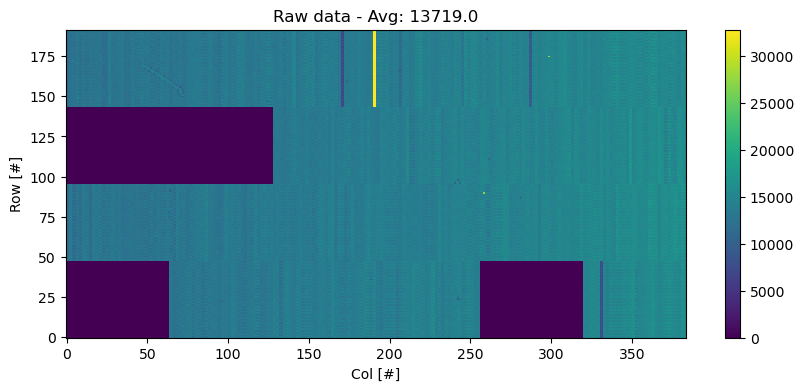

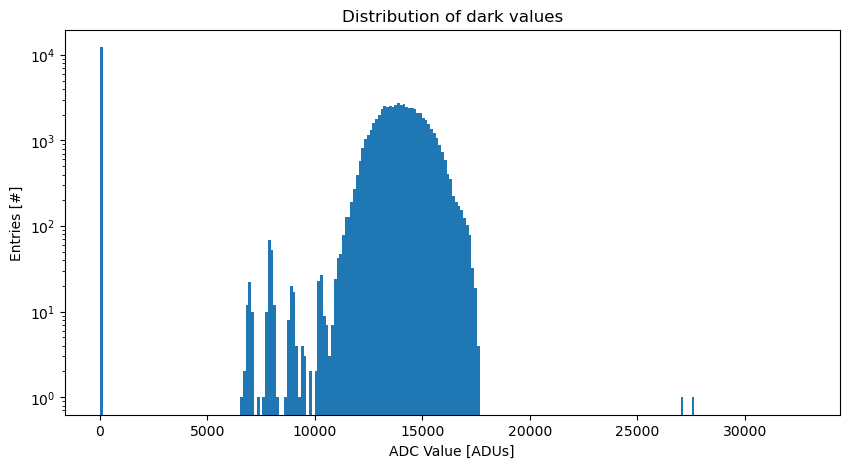

In [75]:
# Plot raw data and histogram
dataTimeAvg = np.average(data,axis=2)

print(np.shape(dataTimeAvg))

plt.figure(figsize = (10,4))
plt.imshow(dataTimeAvg, interpolation='none', aspect='auto', origin='lower', vmax=2**15)
plt.ylabel("Row [#]")
plt.xlabel("Col [#]")
plt.title("Raw data - Avg: {:}".format(getMedianDark(data)))
plt.colorbar()

plt.figure(figsize = (10,5))
plt.hist(dataTimeAvg.flatten(), range=[0,2**15],bins=2**8, log=True)
plt.title("Distribution of dark values")
plt.ylabel("Entries [#]")
plt.xlabel("ADC Value [ADUs]")

3058
Noise: 62.704340


Text(0.5, 0, 'Noise [ADUs]')

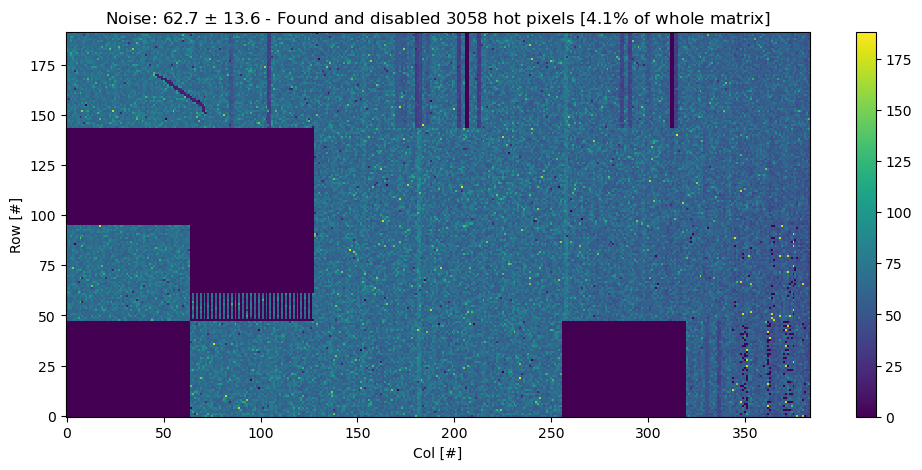

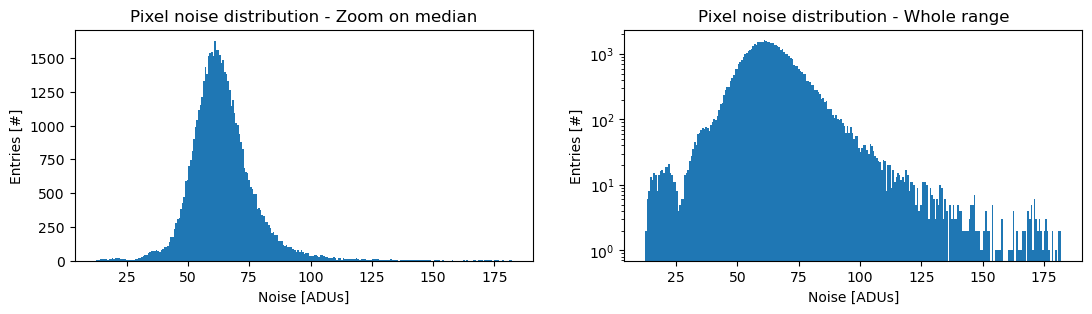

In [76]:
# Uncomment to filter bad pixels!

filterBad = True

if filterBad:
    data_filtered, numBadPixels = filter_bad_pixels(data,3)
else:
    data_filtered, numBadPixels = data, 0


print(numBadPixels)

# Calculate data_noisemap
data_noisemap = np.std(data_filtered, axis=2)

# Flatten array
noisemap_flat = data_noisemap.flatten()

# Remove 0 noise (lanes not locked)
noisemap_flat = noisemap_flat[noisemap_flat > 0]

median_noise = np.median(noisemap_flat)
std_noise    = np.std(noisemap_flat)

# Get outliers (calculated as *2 noise)
noisemap_outliers = noisemap_flat[noisemap_flat > median_noise*2]

print('Noise: {:3f}'.format(median_noise))

# Top plot
plt.figure(figsize=(12,5))
plt.imshow(data_noisemap, interpolation='none', aspect='auto', vmin=0, vmax=median_noise*3, origin='lower')
plt.ylabel("Row [#]")
plt.xlabel("Col [#]")
plt.title(r'Noise: {:.1f} $\pm$ {:.1f} - Found and disabled {:.0f} hot pixels [{:.1f}% of whole matrix]'.format(median_noise, std_noise, numBadPixels, numBadPixels*100/(192.0*384.0)))
plt.colorbar()

# Bottom plot
fig, ax = plt.subplots(1,2, figsize=(13,3))

ax[0].hist(data_noisemap[(data_noisemap < 400) & (data_noisemap > 1)].flatten(),bins=2**8)
ax[0].set_title("Pixel noise distribution - Zoom on median")
ax[0].set_ylabel("Entries [#]")
ax[0].set_xlabel("Noise [ADUs]")

ax[1].hist(data_noisemap[(data_noisemap > 1)].flatten(),bins=2**8,log=True)
ax[1].set_title("Pixel noise distribution - Whole range")
ax[1].set_ylabel("Entries [#]")
ax[1].set_xlabel("Noise [ADUs]")



Text(0.5, 1.0, 'Dark-subtracted image')

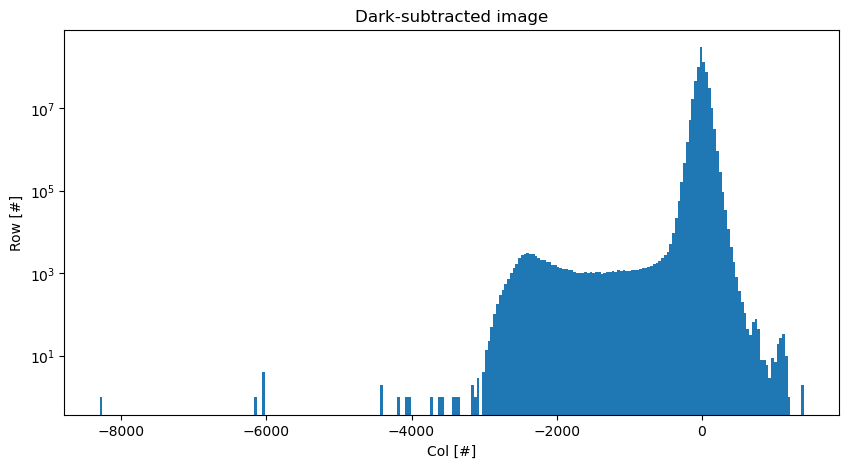

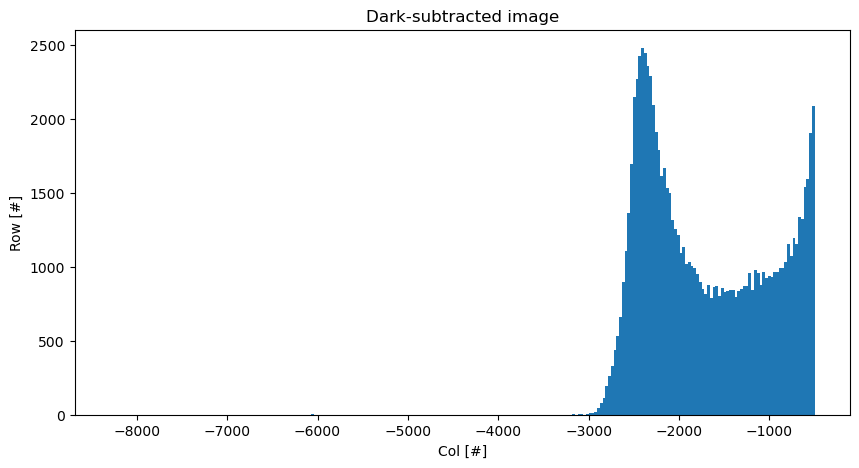

In [77]:
# Subtract mean and display image
dataDarkSub = data_filtered - np.median(data_filtered, axis=2, keepdims=True)

# Trim range here if needed
dataDarkSub = dataDarkSub[(dataDarkSub > -10000)]

# Trim range here if needed
dataDarkSub2 = dataDarkSub[(dataDarkSub < -500)]


plt.figure(figsize = (10,5))
plt.hist(dataDarkSub.flatten(),bins=2**8, log=True)
plt.ylabel("Row [#]")
plt.xlabel("Col [#]")
plt.title("Dark-subtracted image")

plt.figure(figsize = (10,5))
plt.hist(dataDarkSub2.flatten(),bins=2**8)
plt.ylabel("Row [#]")
plt.xlabel("Col [#]")
plt.title("Dark-subtracted image")

In [83]:
root.enableDataRcv(False)
root.disableAndCleanAllFullRateDataRcv()
root.enableAllAsics(True)
root.enableDataDebug(False)

ssdPath = "/u1/ePixHRM320k/acquisition"
filename = f"{ssdPath}/03062024_Fe55_50V_RX000_10000F_ASIC0A3_.dat"

rate = 1000 # HZ
frames = 10000

root.acquireToFile(filename, frames, rate)

Acquisition started: filename: /u1/ePixHRM320k/acquisition/03062024_Fe55_50V_RX000_10000F_ASIC0-3_2.dat, rate: 1000, #frames:10000
Stop Triggers command executed
Set Auto Trigger command executed
Start Auto Trigger command executed
Triggers sent: 10000
Stop Triggers command executed
Received on channel 0 61 frames...
Received on channel 1 7571 frames...
Received on channel 2 7576 frames...
Received on channel 3 7579 frames...
Waiting for file to close...
Acquisition complete and file closed


In [71]:
# Read data

root.readFromFile(filename)

In [72]:
np.shape(root.readerReceiver[1].getData())

(192, 384, 10000)

In [73]:
root.readerReceiver[1].getData()

array([[[    0,     0,     0, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0,     0,     0],
        ...,
        [16239, 16376, 16343, ..., 16257, 16337, 16363],
        [15548, 15573, 15559, ..., 15540, 15581, 15575],
        [15787, 15796, 15716, ..., 15740, 15826, 15733]],

       [[    0,     0,     0, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0,     0,     0],
        ...,
        [16909, 16816, 16856, ..., 16937, 16876, 16895],
        [15785, 15803, 15853, ..., 15817, 15858, 15853],
        [15785, 15663, 15715, ..., 15744, 15694, 15744]],

       [[    0,     0,     0, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0,     0,     0],
        ...,
        [16237, 16223, 16229, ..., 16234, 16209, 16196],
        [15610, 15671, 15612, ..., 15531, 156

# Run when we are done

In [ ]:
# Disable data debug so it does not store data infinitely and crash software
dataDebug.cleanData()
print(dataDebug.getData().shape)
root.enableDataDebug(False)